# Data import for resonant gluon fusion

## Import

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import sys
import uproot3
import pandas as pd
    
from sklearn.model_selection import train_test_split

# sys.path.append('../')
sys.path.append('../../')
from modules.data_import import *
#from modules.basics import *
#from modules.model_export import *
from modules.features import *

### Data

In [2]:
"""
Initialize some variables to be taken as arguements later - currently unsure what samples
"""
mass_cut = False
mass_eff = 90
res_mass = [900]

In [3]:
"""
New, more efficient, import method as compared to what we did in the binary classification example
"""
# path to data files
PATH = Path('../../../MC')
signal = {'GluGluToRadionToHHTo2B2ZTo2L2J_M-'+str(i)+'_narrow_13TeV-madgraph-v2': uproot3.open(PATH/('GluGluToRadionToHHTo2B2ZTo2L2J_M-'+str(i)+'_narrow_13TeV-madgraph-v2.root'))["Events"] for i in res_mass}
background = {i: uproot3.open(PATH/(i+'.root'))["Events"] for i in\
              ['DYJetsToLL_M-10to50_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8', 'DYToLL_0J_13TeV-amcatnloFXFX-pythia8',\
               'DYToLL_1J_13TeV-amcatnloFXFX-pythia8','DYToLL_2J_13TeV-amcatnloFXFX-pythia8']}
print(background)
signal

{'DYJetsToLL_M-10to50_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8': <TTree b'Events' at 0x026fe7a85dc0>, 'DYToLL_0J_13TeV-amcatnloFXFX-pythia8': <TTree b'Events' at 0x026fefc36370>, 'DYToLL_1J_13TeV-amcatnloFXFX-pythia8': <TTree b'Events' at 0x026ff80006d0>, 'DYToLL_2J_13TeV-amcatnloFXFX-pythia8': <TTree b'Events' at 0x026ff832e610>}


{'GluGluToRadionToHHTo2B2ZTo2L2J_M-900_narrow_13TeV-madgraph-v2': <TTree b'Events' at 0x026fdfa0bb50>}

In [4]:
feats = ["Higgsbb_cand_pt","Zjet_cand_pt",
            "leading_Hbb_pt","trailing_Hbb_pt","leading_jet_pt","trailing_jet_pt",
             "Higgsbb_cand_mass","HiggsZZ_cand_mass","Zlep_cand_mass",
             "Zjet_cand_mass","Zlep_cand_pt",         
             "dR_l1j1","dR_l1j2","dR_l1b1","dR_l1b2",
             "dR_l2j1","dR_l2j2","dR_l2b1","dR_l2b2",
             "dR_j1j2","dR_b1b2"]

# these are the extra variables (outside the selected variables) used for preselection cut
#pre_feats = ["Pt_muon1", "Pt_muon2","isMuonEvent", "pass_HLT_Mu17_Mu8"]
pre_feats = ["ngood_bjets", "leading_lep_pt", "trailing_lep_pt", "lep_category"]

In [5]:
"""
Create our signal and background DataFrames
This can be made more efficient by appending a list then making a DataFrame rather than appending a df in a loop
"""
# create signal DataFrame
for i, tree in enumerate(signal.values()):
    if i == 0:
        pre_sig_df = tree.pandas.df(feats+pre_feats)
        pre_sig_df['res_mass'] = res_mass[i]
    else:
        add_df = tree.pandas.df(feats+pre_feats)
        add_df['res_mass'] = res_mass[i]
        pre_sig_df = pre_sig_df.append(add_df, ignore_index=True)
print('shape of signal df before preselection cuts: {}'.format(pre_sig_df.shape))
        
# create background DataFrame
for i, tree in enumerate(background.values()):
    if i == 0:
        pre_bkg_df = tree.pandas.df(feats+pre_feats)
        pre_bkg_df['res_mass'] = np.nan
    else:
        add_df = tree.pandas.df(feats+pre_feats)
        add_df['res_mass'] = np.nan
        pre_bkg_df = pre_bkg_df.append(add_df, ignore_index=True)
print('shape of background df before preselection cuts: {}'.format(pre_bkg_df.shape))

shape of signal df before preselection cuts: (65639, 26)
shape of background df before preselection cuts: (1682102, 26)


In [6]:
"""
Apply preselection cuts, drop uneeded features
"""
sig_df = pd.DataFrame(pre_sig_df.loc[(pre_sig_df.ngood_bjets > 0) & (pre_sig_df.lep_category == 2) & (pre_sig_df.Zlep_cand_mass > 15) &
                                     (pre_sig_df.leading_lep_pt > 20) & (pre_sig_df.trailing_lep_pt > 10) & (pre_sig_df.leading_Hbb_pt > 20) &
                                     (pre_sig_df.trailing_Hbb_pt > 20) & (pre_sig_df.leading_jet_pt > 20) & (pre_sig_df.trailing_jet_pt > 20)])
bkg_df = pd.DataFrame(pre_bkg_df.loc[(pre_bkg_df.ngood_bjets > 0) & (pre_bkg_df.lep_category == 2) & (pre_bkg_df.Zlep_cand_mass > 15) & 
                                     (pre_sig_df.leading_lep_pt > 20) & (pre_sig_df.trailing_lep_pt > 10) & (pre_sig_df.leading_Hbb_pt > 20) &
                                     (pre_bkg_df.trailing_Hbb_pt > 20) & (pre_bkg_df.leading_jet_pt > 20) & (pre_bkg_df.trailing_jet_pt > 20)])

# drop preselection features that are not in our desired features
sig_df.drop(columns=[f for f in pre_feats], inplace=True)
bkg_df.drop(columns=[f for f in pre_feats], inplace=True)

print('shape of signal df after preselection cuts: {}'.format(sig_df.shape))
print('shape of background df after preselection cuts: {}'.format(bkg_df.shape))

shape of signal df after preselection cuts: (36413, 22)
shape of background df after preselection cuts: (32984, 22)


In [36]:
"""
Add signal/background flags and renormalize? - renormalization may be done at the weight balance section later
"""
# now we append the data frames to add signal/background flags
sig_df['Label'] = 1
# df2.head()
bkg_df['Label'] = 0
# df3.head()

# normalize signal/background weights separately
# sig_df.weight_central /= sig_df.weight_central.sum()
# bkg_df.weight_central /= bkg_df.weight_central.sum()

In [37]:
"""
Append signal and background now and rename some features for LUMIN
split the full MC data into two sets based off event_id being even or odd
"""
df_0 = sig_df[::2].append(bkg_df[::2], ignore_index=True)
df_1 = sig_df[1::2].append(bkg_df[1::2], ignore_index=True)
df_0.rename(index=str, columns={'Label':'gen_target', 'weight_central':'gen_weight'}, inplace=True)
df_1.rename(index=str, columns={'Label':'gen_target', 'weight_central':'gen_weight'}, inplace=True)

# add weights=1 for now
df_0['gen_weight'] = 1
df_1['gen_weight'] = 1

df_0

,Higgsbb_cand_pt,Zjet_cand_pt,leading_Hbb_pt,trailing_Hbb_pt,leading_jet_pt,trailing_jet_pt,Higgsbb_cand_mass,HiggsZZ_cand_mass,Zlep_cand_mass,Zjet_cand_mass,...,dR_l1b2,dR_l2j1,dR_l2j2,dR_l2b1,dR_l2b2,dR_j1j2,dR_b1b2,res_mass,gen_target,gen_weight
0,470.274078,69.387245,197.698395,281.912811,68.283752,56.930706,144.301208,308.775360,51.124199,106.675987,...,3.062102,1.641656,0.637177,3.062136,2.843800,1.993926,0.566757,900.0,1,1
1,508.262238,139.129593,270.960388,462.437012,124.875504,78.482559,621.973267,604.346436,92.035095,181.038681,...,2.594162,2.842100,1.852190,2.624687,2.122317,1.951550,1.898677,900.0,1,1
2,144.603714,69.748596,112.283226,33.257378,37.629398,35.917488,48.743980,137.288315,31.433678,45.852699,...,3.933781,1.271678,0.724459,3.411037,3.674039,1.136367,0.692858,900.0,1,1
3,305.430603,187.896576,201.409149,104.021667,157.131149,31.091839,95.106430,456.325012,39.843067,164.231400,...,3.005884,2.297199,3.191049,2.997528,3.055274,1.977447,0.622081,900.0,1,1
4,455.936859,50.424240,232.653976,230.251389,49.505882,44.220039,131.587875,290.659668,90.616653,128.798721,...,3.084234,1.391868,1.564121,2.988608,2.766721,2.742136,0.539140,900.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34694,59.049286,71.625648,42.095840,55.439888,42.095840,34.667339,116.752502,184.746735,89.823639,34.342392,...,2.000053,2.867027,2.007397,2.867027,1.903946,0.861097,2.462983,NaN,0,1
34695,31.115753,66.712364,66.056831,35.017761,37.011463,31.226738,102.421700,191.063034,89.446732,80.019081,...,3.389005,2.675657,2.614732,2.226691,3.357132,2.009092,3.166710,NaN,0,1
34696,5.264352,4.746346,48.372581,43.166534,43.166534,39.856781,97.837616,317.408173,90.877579,121.639153,...,2.920420,3.409015,1.587543,3.750095,3.409015,3.572216,3.193170,NaN,0,1
34697,58.485973,69.355949,47.027954,42.237236,42.237236,41.758789,71.069183,211.135696,91.373497,50.089325,...,3.130891,1.468939,2.485677,3.054137,1.468939,1.209079,1.762242,NaN,0,1


In [38]:
df_1

,Higgsbb_cand_pt,Zjet_cand_pt,leading_Hbb_pt,trailing_Hbb_pt,leading_jet_pt,trailing_jet_pt,Higgsbb_cand_mass,HiggsZZ_cand_mass,Zlep_cand_mass,Zjet_cand_mass,...,dR_l1b2,dR_l2j1,dR_l2j2,dR_l2b1,dR_l2b2,dR_j1j2,dR_b1b2,res_mass,gen_target,gen_weight
0,375.418915,71.730560,103.911789,280.417694,51.486023,31.303640,96.344688,296.791565,81.792267,68.787354,...,2.422785,2.091218,0.467008,2.385195,1.885081,1.646023,0.526729,900.0,1,1
1,405.033081,20.930138,342.810577,67.703186,46.823524,42.669544,134.217072,292.647858,91.762306,94.201126,...,2.970528,2.497824,0.837069,2.879490,2.689666,2.781203,0.831057,900.0,1,1
2,408.706512,78.412415,157.788513,257.794281,54.396488,33.901123,117.558556,342.032501,40.641705,43.385303,...,2.930879,2.538680,1.974642,2.890465,3.147540,0.992369,0.551276,900.0,1,1
3,542.198486,189.096771,249.835434,292.726929,249.835434,61.377304,115.968681,529.753357,84.036270,252.922226,...,2.899200,2.090648,0.963384,2.090648,1.979268,3.042451,0.411822,900.0,1,1
4,437.543213,98.585472,329.776459,110.177544,106.946754,35.079365,131.327118,372.891327,46.834667,242.401123,...,2.989858,0.717841,2.758610,2.843619,3.188301,3.336573,0.651741,900.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34693,20.930601,34.492958,42.331570,31.049593,31.049593,30.932108,79.341690,241.835236,90.667007,136.628281,...,1.743449,2.906658,2.307081,1.368035,2.906658,3.512996,2.805960,NaN,0,1
34694,66.425354,21.488510,33.824760,34.846210,38.709976,33.824760,47.218422,215.721497,91.177307,76.601898,...,2.306234,2.831444,1.956510,1.956510,1.106626,2.674582,1.235530,NaN,0,1
34695,19.238626,29.578041,54.392437,36.535259,36.535259,32.348427,282.366943,227.674789,92.570869,86.928566,...,2.545063,0.708752,2.634241,4.278740,0.708752,2.753667,4.703377,NaN,0,1
34696,43.352741,46.843121,30.825518,35.758923,37.197556,31.602158,54.823448,185.267624,90.473427,58.884865,...,2.026924,2.273292,0.519659,1.633441,2.746582,1.834391,1.815135,NaN,0,1


In [39]:
# define the same sets of features as in the binary classification example
targ_feat = 'gen_target'
gen_feats = [f for f in df_1.columns if 'gen_' in f]
misc_feats = []
wgt_feat = 'gen_weight'
cat_feats = []
cont_feats = [f for f in df_1.columns if f not in gen_feats+cat_feats+misc_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats

0 []
22 ['Higgsbb_cand_pt', 'Zjet_cand_pt', 'leading_Hbb_pt', 'trailing_Hbb_pt', 'leading_jet_pt', 'trailing_jet_pt', 'Higgsbb_cand_mass', 'HiggsZZ_cand_mass', 'Zlep_cand_mass', 'Zjet_cand_mass', 'Zlep_cand_pt', 'dR_l1j1', 'dR_l1j2', 'dR_l1b1', 'dR_l1b2', 'dR_l2j1', 'dR_l2j2', 'dR_l2b1', 'dR_l2b2', 'dR_j1j2', 'dR_b1b2', 'res_mass']


To create our validation set, we'll eventually pull out a random sample, however it can be useful to ensure as much similarity as possible by doing a stratified split using the categories and classes in the data. `ids2unique` maps each set of categories to a unique integer, allowing us to create a single set of values to use as the stratification key.

In [40]:
# Again, we need the 'strat_key' feature as in the binary classification example
from lumin.utils.misc import ids2unique
df_0['gen_strat_key'] = ids2unique(df_0[[targ_feat] + cat_feats].values)
df_0.rename(index=str, columns={'strat_key':'gen_strat_key'}, inplace=True)
df_1['gen_strat_key'] = ids2unique(df_1[[targ_feat] + cat_feats].values)
df_1.rename(index=str, columns={'strat_key':'gen_strat_key'}, inplace=True)
# test.rename(index=str, columns={'strat_key':'gen_strat_key'}, inplace=True)

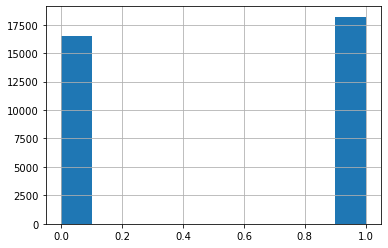

In [41]:
"""
Plots the binary target for both DataFrames
"""
df_0.gen_target.hist()

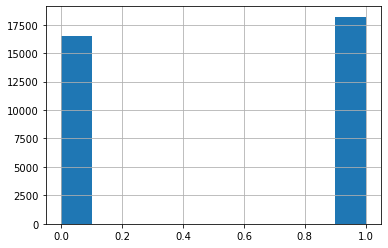

In [42]:
df_1.gen_target.hist()

In [43]:
df_0.gen_weight.describe()

count    34699.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: gen_weight, dtype: float64

In [44]:
df_0.res_mass.unique()

array([900.,  nan])

# > *Setup the features same as in the binary classification example* <
## Features

In [45]:
"""
Defined previously when the data was first imported
"""
# cont_feats, cat_feats, train_feats = sort_feats(df_0, remove_vbf=True, use_feats=use_feats)

'\nDefined previously when the data was first imported\n'

In [46]:
cat_feats

[]

In [47]:
len(cont_feats), cont_feats

(22,
 ['Higgsbb_cand_pt',
  'Zjet_cand_pt',
  'leading_Hbb_pt',
  'trailing_Hbb_pt',
  'leading_jet_pt',
  'trailing_jet_pt',
  'Higgsbb_cand_mass',
  'HiggsZZ_cand_mass',
  'Zlep_cand_mass',
  'Zjet_cand_mass',
  'Zlep_cand_pt',
  'dR_l1j1',
  'dR_l1j2',
  'dR_l1b1',
  'dR_l1b2',
  'dR_l2j1',
  'dR_l2j2',
  'dR_l2b1',
  'dR_l2b2',
  'dR_j1j2',
  'dR_b1b2',
  'res_mass'])

## Resonant Mass

In [48]:
"""
add_bkg_res_mass() is interesting - in the given DataFrame, it sets the background 'res_mass' feature vector equal to
randomly chosen values from the unique set of values from the DataFrames signal 'res_mass' feature. It then copies
the entire column of 'res_mass' from the DataFrame into a new column 'int_res_mass'

essentially gives a random spread of mass points to the background of the dataframe
"""
add_bkg_res_mass(df_0)
add_bkg_res_mass(df_1)

In [49]:
# check to see if NaN's are now gone
df_0.res_mass.unique()

array([900.])

No handles with labels found to put in legend.


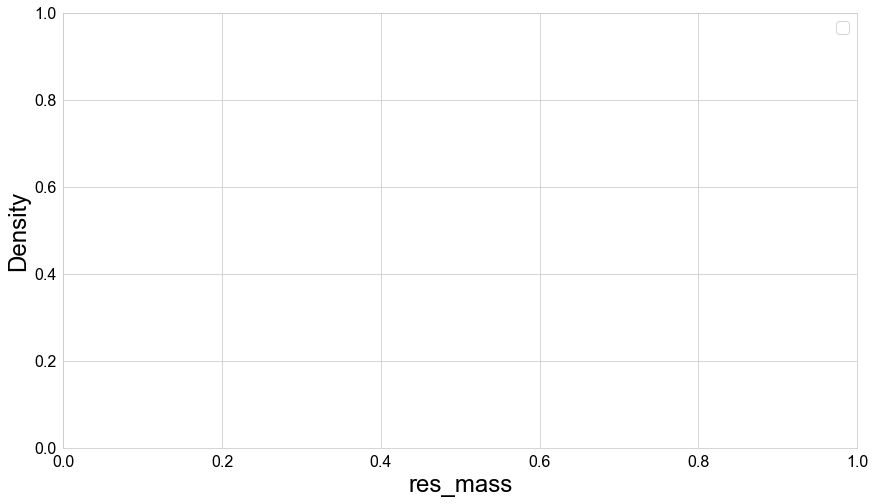

In [50]:
"""
Only goes up to 900GeV?
"""
from lumin.plotting.data_viewing import plot_feat
plot_feat(df_0, 'res_mass', cuts=[(df_0.gen_target==0),(df_0.gen_target==1)], labels=['Bkg.', 'Sig.'])

In [51]:
df_0['res_mass_orig'] = df_0['res_mass']
df_1['res_mass_orig'] = df_1['res_mass']

## Data preprocessing 

In [52]:
input_pipe_0 = fit_input_pipe(df_0, cont_feats, PATH/f'input_pipe_0_untrained')
input_pipe_1 = fit_input_pipe(df_1, cont_feats, PATH/f'input_pipe_1_untrained')

In [53]:
set_0_train = df_0.copy()
set_1_train = df_1.copy()
set_0_test  = df_0.copy()
set_1_test  = df_1.copy()

In [54]:
set_0_train[cont_feats] = input_pipe_0.transform(set_0_train[cont_feats].values.astype('float32'))
set_1_train[cont_feats] = input_pipe_1.transform(set_1_train[cont_feats].values.astype('float32'))

In [55]:
set_0_test[cont_feats] = input_pipe_1.transform(set_0_test[cont_feats].values.astype('float32'))
set_1_test[cont_feats] = input_pipe_0.transform(set_1_test[cont_feats].values.astype('float32'))

## Weight balancing

In [56]:
set_0_train

,Higgsbb_cand_pt,Zjet_cand_pt,leading_Hbb_pt,trailing_Hbb_pt,leading_jet_pt,trailing_jet_pt,Higgsbb_cand_mass,HiggsZZ_cand_mass,Zlep_cand_mass,Zjet_cand_mass,...,dR_l2b1,dR_l2b2,dR_j1j2,dR_b1b2,res_mass,gen_target,gen_weight,gen_strat_key,int_res_mass,res_mass_orig
0,1.605999,-0.334139,0.623690,1.396473,-0.296862,0.428413,-0.107711,-0.181405,-0.724651,-0.233716,...,0.604960,0.421375,-0.187841,-1.188910,0.0,1,1,2,900.0,900.0
1,1.825137,0.408075,1.219630,2.912358,0.357421,1.259053,2.703150,1.220863,0.660695,0.388351,...,0.096370,-0.388649,-0.231086,-0.028089,0.0,1,1,2,900.0,900.0
2,-0.272656,-0.330293,-0.071109,-0.691520,-0.651271,-0.381467,-0.670017,-0.994986,-1.391422,-0.742523,...,1.010601,1.353503,-1.062977,-1.079008,0.0,1,1,2,900.0,900.0
3,0.655087,0.927064,0.653874,-0.097303,0.730343,-0.567455,-0.397197,0.518610,-1.106658,0.247753,...,0.529845,0.658802,-0.204657,-1.140693,0.0,1,1,2,900.0,900.0
4,1.523294,-0.535947,0.908032,0.962665,-0.513961,-0.061475,-0.182522,-0.267351,0.612663,-0.048653,...,0.519474,0.334837,0.575705,-1.212979,0.0,1,1,2,900.0,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34694,-0.766183,-0.310317,-0.642040,-0.505250,-0.599632,-0.429650,-0.269821,-0.769830,0.585810,-0.838810,...,0.378121,-0.633819,-1.343890,0.463725,0.0,0,1,1,900.0,900.0
34695,-0.927320,-0.362605,-0.447132,-0.676738,-0.658415,-0.562256,-0.354151,-0.739864,0.573047,-0.456710,...,-0.366349,0.997705,-0.172364,1.077051,0.0,0,1,1,900.0,900.0
34696,-1.076446,-1.022061,-0.590982,-0.608311,-0.587253,-0.229641,-0.381126,-0.140449,0.621499,-0.108545,...,1.404798,1.055954,1.422799,1.100112,0.0,0,1,1,900.0,900.0
34697,-0.769433,-0.334472,-0.601920,-0.616115,-0.597997,-0.156335,-0.538645,-0.644634,0.638292,-0.707082,...,0.595660,-1.122211,-0.988774,-0.146998,0.0,0,1,1,900.0,900.0


In [57]:
"""
Need to redefine the check_weights and balance_weights_resonant methods since we have different features
"""
# balance_weights_resonant?
# balance_weights_resonant(set_train)

def check_weights_resonant(df:pd.DataFrame) -> None:
    v = []
    for m in df.int_res_mass.unique():
        v.append(df.loc[(df.gen_target == 1) & (df.int_res_mass==m), 'gen_weight'].sum())
        print(m, 'sum', v[-1])
    print(f'res mass std {np.std(v):.2f}')

def new_balance_weights_resonant(df:pd.DataFrame) -> None:
    print('Initial weight sums')
    check_weights_resonant(df)
    df['gen_orig_weight'] = df['gen_weight']
    for t in df.gen_target.unique():
        for m in df.int_res_mass.unique():
            df.loc[(df.gen_target == t) & (df.int_res_mass == m), 'gen_weight'] \
                /= np.sum(df.loc[(df.gen_target == t) & (df.int_res_mass == m), 'gen_weight'])

    print('\nFinal weight sums')
    check_weights_resonant(df)

In [58]:
new_balance_weights_resonant(set_0_train)

Initial weight sums
900.0 sum 18207
res mass std 0.00

Final weight sums
900.0 sum 0.9999999999999996
res mass std 0.00


In [59]:
new_balance_weights_resonant(set_1_train)

Initial weight sums
900.0 sum 18206
res mass std 0.00

Final weight sums
900.0 sum 0.9999999999999998
res mass std 0.00


# > *Do this the same as we did in binary classification* <
## Saving

In [60]:
# df2foldfile(df=set_0_train, n_folds=10,
#             cont_feats=cont_feats, cat_feats=cat_feats, targ_feats='gen_target', wgt_feat='gen_weight',
#             misc_feats=['channel', 'gen_sample', 'gen_orig_weight', 'jet_cat', 'gen_strat_key', 'res_mass_orig'],
#             savename=PATH/'train_0', targ_type='int', strat_key='gen_strat_key')

df2foldfile(df=set_0_train, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats='gen_target', wgt_feat='gen_weight',
            misc_feats=['gen_orig_weight', 'gen_strat_key', 'res_mass_orig'],
            savename=PATH/'train_0_untrained', targ_type='int', strat_key='gen_strat_key')

Saving fold 0 with 3470 events
Saving fold 1 with 3470 events
Saving fold 2 with 3470 events
Saving fold 3 with 3470 events
Saving fold 4 with 3470 events
Saving fold 5 with 3470 events
Saving fold 6 with 3470 events
Saving fold 7 with 3470 events
Saving fold 8 with 3470 events
Saving fold 9 with 3469 events


In [61]:
# df2foldfile(df=set_1_train, n_folds=10,
#             cont_feats=cont_feats, cat_feats=cat_feats, targ_feats='gen_target', wgt_feat='gen_weight',
#             misc_feats=['channel', 'gen_sample', 'gen_orig_weight', 'jet_cat', 'gen_strat_key', 'res_mass_orig'],
#             savename=PATH/'train_1', targ_type='int', strat_key='gen_strat_key')

df2foldfile(df=set_1_train, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats='gen_target', wgt_feat='gen_weight',
            misc_feats=['gen_orig_weight', 'gen_strat_key', 'res_mass_orig'],
            savename=PATH/'train_1_untrained', targ_type='int', strat_key='gen_strat_key')

Saving fold 0 with 3470 events
Saving fold 1 with 3470 events
Saving fold 2 with 3470 events
Saving fold 3 with 3470 events
Saving fold 4 with 3470 events
Saving fold 5 with 3470 events
Saving fold 6 with 3470 events
Saving fold 7 with 3470 events
Saving fold 8 with 3469 events
Saving fold 9 with 3469 events


In [62]:
# df2foldfile(df=set_0_test, n_folds=10,
#             cont_feats=cont_feats, cat_feats=cat_feats, targ_feats='gen_target', wgt_feat='gen_weight',
#             misc_feats=['channel', 'gen_sample', 'jet_cat', 'gen_strat_key', 'mva_score', 'res_mass_orig'],
#             savename=PATH/'test_0', targ_type='int', strat_key='gen_strat_key')

df2foldfile(df=set_0_test, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats='gen_target', wgt_feat='gen_weight',
            misc_feats=['gen_strat_key', 'res_mass_orig'],
            savename=PATH/'test_0_untrained', targ_type='int', strat_key='gen_strat_key')

Saving fold 0 with 3470 events
Saving fold 1 with 3470 events
Saving fold 2 with 3470 events
Saving fold 3 with 3470 events
Saving fold 4 with 3470 events
Saving fold 5 with 3470 events
Saving fold 6 with 3470 events
Saving fold 7 with 3470 events
Saving fold 8 with 3470 events
Saving fold 9 with 3469 events


In [63]:
# df2foldfile(df=set_1_test, n_folds=10,
#             cont_feats=cont_feats, cat_feats=cat_feats, targ_feats='gen_target', wgt_feat='gen_weight',
#             misc_feats=['channel', 'gen_sample', 'jet_cat', 'gen_strat_key', 'mva_score', 'res_mass_orig'],
#             savename=PATH/'test_1', targ_type='int', strat_key='gen_strat_key')

df2foldfile(df=set_1_test, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats='gen_target', wgt_feat='gen_weight',
            misc_feats=['gen_strat_key', 'res_mass_orig'],
            savename=PATH/'test_1_untrained', targ_type='int', strat_key='gen_strat_key')

Saving fold 0 with 3470 events
Saving fold 1 with 3470 events
Saving fold 2 with 3470 events
Saving fold 3 with 3470 events
Saving fold 4 with 3470 events
Saving fold 5 with 3470 events
Saving fold 6 with 3470 events
Saving fold 7 with 3470 events
Saving fold 8 with 3469 events
Saving fold 9 with 3469 events
